In [1]:
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
titanic = pd.read_csv('titanic.csv')
titanic[:2]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [3]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


# 타이타닉 생존자 예측

## 전처리
- 결측치
    - 나이 : 평균
    - 선실번호(Cabin) : N
    - 중간 정착 항구(Embarked) : N
- 레이블 인코딩 : 성별, 선실 번호, 중간 정착 항구
- 피처 제거 : PassengerId, Name, Ticket

### 피처 제거

In [4]:
titanic.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [5]:
titanic = titanic[['Survived', 'Pclass','Sex', 'Age','SibSp',
       'Parch','Fare', 'Cabin', 'Embarked']]
titanic[:2]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,NaN,S
1,1,1,female,38.0,1,0,71.2833,C85,C


### 결측치 처리

#### Age 컬럼 결측치 처리

In [6]:
# 결측치 확인
titanic.isna().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [7]:
# Age 컬럼 결측치 평균으로 변경(복사본)
titanic.Age.fillna(titanic.Age.mean()).isna().sum()

0

In [8]:
# Age 컬럼 결측치 평균으로 변경 후 원본 적용
titanic.Age.fillna(titanic.Age.mean(), inplace=True)

In [9]:
# 나이가 1 이하인 값 확인
(titanic.Age < 1).value_counts()
# 나이가 1 이하인 값이 존재하기 때문에 dtype 변경 x

Age
False    884
True       7
Name: count, dtype: int64

#### 선실번호, 중간 정착 항구 결측치 처리

In [10]:
# 결측치 확인
titanic.isna().sum()

Survived      0
Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [11]:
# 결측치 처리(복사본)
titanic.fillna('N').isna().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Cabin       0
Embarked    0
dtype: int64

In [12]:
# 결측치 처리 적용
titanic.fillna('N', inplace=True)

In [13]:
# 결측치 처리 확인
titanic.isna().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Cabin       0
Embarked    0
dtype: int64

### 레이블 인코딩
- Sex, Cabin, Embarked

In [14]:
# LabelEncoder 객체 생성
encoder = LabelEncoder()

In [15]:
# 성별 인코딩
sex_encoder = encoder.fit(titanic.Sex)
titanic.Sex = sex_encoder.transform(titanic.Sex)
sex_encoder.classes_

array(['female', 'male'], dtype=object)

In [16]:
# 선실 번호의 앞 문자만 사용하기 위해 슬라이싱
titanic.Cabin = titanic.Cabin.str[:1]

In [17]:
# 선실 번호 인코딩
cabin_encoder = encoder.fit(titanic.Cabin)
titanic.Cabin = cabin_encoder.transform(titanic.Cabin)
cabin_encoder.classes_

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'N', 'T'], dtype=object)

In [18]:
# 중간 정착 항구
embarked_encoder = encoder.fit(titanic.Embarked)
titanic.Embarked = embarked_encoder.transform(titanic.Embarked)
embarked_encoder.classes_

array(['C', 'N', 'Q', 'S'], dtype=object)

### 전처리 후 데이터프레임

In [19]:
# 전처리 후 데이터프레임
titanic[:10]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,1,22.000000,1,0,7.2500,7,3
1,1,1,0,38.000000,1,0,71.2833,2,0
2,1,3,0,26.000000,0,0,7.9250,7,3
3,1,1,0,35.000000,1,0,53.1000,2,3
4,0,3,1,35.000000,0,0,8.0500,7,3
5,0,3,1,29.699118,0,0,8.4583,7,2
6,0,1,1,54.000000,0,0,51.8625,4,3
7,0,3,1,2.000000,3,1,21.0750,7,3
8,1,3,0,27.000000,0,2,11.1333,7,3
9,1,2,0,14.000000,1,0,30.0708,7,0


## DecisionTreeClassifier : 학습/예측/평가

In [20]:
# feature, target 분리
t_feature = titanic.iloc[:,1:]
t_target = titanic.iloc[:,0]

In [21]:
# 학습, 테스트 데이터 분리
x_train, x_test, y_train, y_test = train_test_split(
    t_feature,
    t_target,
    test_size=0.2,
    random_state=11,
    stratify=titanic.Pclass
)

x_train2, x_test2, y_train2, y_test2 = train_test_split(
    t_feature,
    t_target,
    test_size=0.2,
    random_state=11,
    stratify=titanic.Sex
)

x_train3, x_test3, y_train3, y_test3 = train_test_split(
    t_feature,
    t_target,
    test_size=0.2,
    random_state=11,
)

In [22]:
titanic.shape

(891, 9)

In [23]:
x_train.shape

(712, 8)

In [24]:
y_train.shape

(712,)

In [25]:
x_test.shape

(179, 8)

In [26]:
y_test.shape

(179,)

In [27]:
# 결정트리 객체 생성
dt_clf = DecisionTreeClassifier(random_state=11)

In [28]:
# 학습
dt_clf.fit(x_train, y_train)

# 예측
pred = dt_clf.predict(x_test)

# 평가
print('예측 정확도 >>', accuracy_score(y_test, pred))

예측 정확도 >> 0.8100558659217877


In [29]:
# 불필요한 feature 제거 후 학습
# 학습
dt_clf.fit(x_train[['Pclass', 'Sex', 'Age']], y_train)

# 예측
pred = dt_clf.predict(x_test[['Pclass', 'Sex', 'Age']])

# 평가
print('예측 정확도 >>', accuracy_score(y_test, pred))

예측 정확도 >> 0.770949720670391


In [30]:
# 학습
dt_clf.fit(x_train2, y_train2)

# 예측
pred = dt_clf.predict(x_test2)

# 평가
print('예측 정확도 >>', accuracy_score(y_test2, pred))

예측 정확도 >> 0.7262569832402235


In [31]:
# 학습
dt_clf.fit(x_train3, y_train3)

# 예측
pred = dt_clf.predict(x_test3)

# 평가
print('예측 정확도 >>', accuracy_score(y_test3, pred))

예측 정확도 >> 0.7877094972067039


In [32]:
# feature importance
# 학습 중요도
dt_clf.feature_importances_

array([0.0826082 , 0.28371894, 0.24767893, 0.04561896, 0.01963887,
       0.22423181, 0.05628073, 0.04022358])

In [33]:
x_train.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked'], dtype='object')

In [34]:
for col, val in zip(x_train.columns, dt_clf.feature_importances_):
    print(f'{col} : {val}')

Pclass : 0.08260820037500148
Sex : 0.2837189364182245
Age : 0.24767892651898044
SibSp : 0.04561895611637998
Parch : 0.019638870267613618
Fare : 0.2242318050646934
Cabin : 0.05628072854745321
Embarked : 0.04022357669165342


<Axes: >

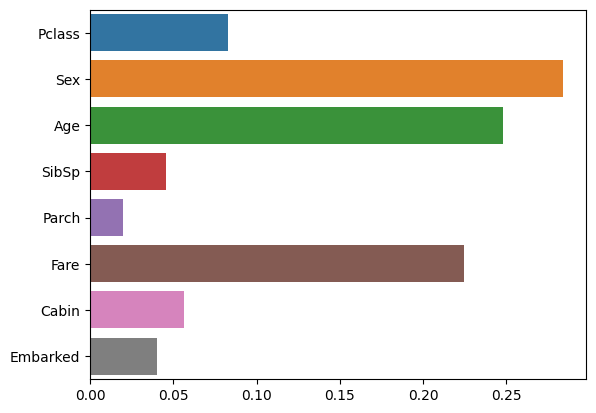

In [35]:
sns.barplot(x=dt_clf.feature_importances_, y=x_train.columns)

In [36]:
# 불필요한 feature 제거 후 학습
# 학습
dt_clf.fit(x_train3[['Pclass', 'Sex', 'Age']], y_train3)

# 예측
pred = dt_clf.predict(x_test3[['Pclass', 'Sex', 'Age']])

# 평가
print('예측 정확도 >>', accuracy_score(y_test3, pred))

예측 정확도 >> 0.8603351955307262


## KFold : fold set = 5

In [37]:
# 폴드 셋이 5개인 KFold 객체 생성
kfold = KFold(n_splits=5)

In [38]:
n_iter = 0
accuracy_list = []

for train_index, test_index in kfold.split(t_feature):
    n_iter += 1
    
    x_train, y_train = t_feature.iloc[train_index], t_target[train_index]
    x_test, y_test = t_feature.iloc[test_index], t_target[test_index]
    
    # 학습
    dt_clf.fit(x_train, y_train)
    
    # 예측
    pred = dt_clf.predict(x_test)
    
    # 평가
    acc = np.round(accuracy_score(y_test, pred), 4)
    accuracy_list.append(acc)
    print(f'[{n_iter}차 평가]')
    print(f'예측 정확도 : {acc}, 학습 데이터 크기 : {x_train.shape[0]}, 검증 데이터 크기 : {x_test.shape[0]}')
    print('=' * 50, end='\n\n')
    
print(f'평균 정확도 : {np.mean(accuracy_list)}')

[1차 평가]
예측 정확도 : 0.7542, 학습 데이터 크기 : 712, 검증 데이터 크기 : 179

[2차 평가]
예측 정확도 : 0.7809, 학습 데이터 크기 : 713, 검증 데이터 크기 : 178

[3차 평가]
예측 정확도 : 0.7865, 학습 데이터 크기 : 713, 검증 데이터 크기 : 178

[4차 평가]
예측 정확도 : 0.7697, 학습 데이터 크기 : 713, 검증 데이터 크기 : 178

[5차 평가]
예측 정확도 : 0.8202, 학습 데이터 크기 : 713, 검증 데이터 크기 : 178

평균 정확도 : 0.7823


In [39]:
accuracy_list = []

for idx, (train_index, test_index) in enumerate(kfold.split(t_feature), 1):
    
#     x_train, y_train = t_feature.iloc[train_index], t_target[train_index]
#     x_test, y_test = t_feature.iloc[test_index], t_target[test_index]
    
    x_train, y_train = t_feature.values[train_index], t_target.values[train_index]
    x_test, y_test = t_feature.values[test_index], t_target.values[test_index]
    
    # 학습
    dt_clf.fit(x_train, y_train)
    
    # 예측
    pred = dt_clf.predict(x_test)
    
    # 평가
    acc = np.round(accuracy_score(y_test, pred), 4)
    accuracy_list.append(acc)
    print(f'[{idx}차 평가]')
    print(f'예측 정확도 : {acc}, 학습 데이터 크기 : {x_train.shape[0]}, 검증 데이터 크기 : {x_test.shape[0]}')
    print('=' * 50, end='\n\n')
    
print(f'평균 정확도 : {np.mean(accuracy_list)}')

[1차 평가]
예측 정확도 : 0.7542, 학습 데이터 크기 : 712, 검증 데이터 크기 : 179

[2차 평가]
예측 정확도 : 0.7809, 학습 데이터 크기 : 713, 검증 데이터 크기 : 178

[3차 평가]
예측 정확도 : 0.7865, 학습 데이터 크기 : 713, 검증 데이터 크기 : 178

[4차 평가]
예측 정확도 : 0.7697, 학습 데이터 크기 : 713, 검증 데이터 크기 : 178

[5차 평가]
예측 정확도 : 0.8202, 학습 데이터 크기 : 713, 검증 데이터 크기 : 178

평균 정확도 : 0.7823


<Axes: >

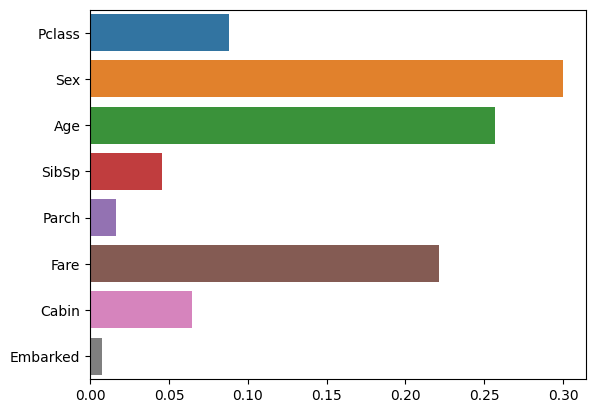

In [40]:
sns.barplot(x=dt_clf.feature_importances_, y=t_feature.columns)

## Stratified KFold : fold set = 5

In [41]:
# 폴드 셋이 5개인 StratifiedKFold 객체 생성
skf = StratifiedKFold(n_splits=5)

In [42]:
accuracy_list = []

for idx, (train_index, test_index) in enumerate(skf.split(t_feature, y=t_target), 1):
    x_train, y_train = t_feature.iloc[train_index], t_target[train_index]
    x_test, y_test = t_feature.iloc[test_index], t_target[test_index]
    
    # 학습
    dt_clf.fit(x_train, y_train)
    
    # 예측
    pred = dt_clf.predict(x_test)
    
    # 평가
    acc = np.round(accuracy_score(y_test, pred), 4)
    accuracy_list.append(acc)
    print(f'[{idx}차 평가]')
    print(f'예측 정확도 : {acc}, 학습 데이터 크기 : {x_train.shape[0]}, 검증 데이터 크기 : {x_test.shape[0]}')
    print('=' * 50, end='\n\n')
    
print(f'평균 정확도 : {np.mean(accuracy_list)}')

[1차 평가]
예측 정확도 : 0.743, 학습 데이터 크기 : 712, 검증 데이터 크기 : 179

[2차 평가]
예측 정확도 : 0.7753, 학습 데이터 크기 : 713, 검증 데이터 크기 : 178

[3차 평가]
예측 정확도 : 0.7921, 학습 데이터 크기 : 713, 검증 데이터 크기 : 178

[4차 평가]
예측 정확도 : 0.7865, 학습 데이터 크기 : 713, 검증 데이터 크기 : 178

[5차 평가]
예측 정확도 : 0.8427, 학습 데이터 크기 : 713, 검증 데이터 크기 : 178

평균 정확도 : 0.78792


In [43]:
accuracy_list = []

for idx, (train_index, test_index) in enumerate(skf.split(t_feature, y=t_feature.Sex), 1):
    x_train, y_train = t_feature.iloc[train_index], t_target[train_index]
    x_test, y_test = t_feature.iloc[test_index], t_target[test_index]
    
    # 학습
    dt_clf.fit(x_train, y_train)
    
    # 예측
    pred = dt_clf.predict(x_test)
    
    # 평가
    acc = np.round(accuracy_score(y_test, pred), 4)
    accuracy_list.append(acc)
    print(f'[{idx}차 평가]')
    print(f'예측 정확도 : {acc}, 학습 데이터 크기 : {x_train.shape[0]}, 검증 데이터 크기 : {x_test.shape[0]}')
    print('=' * 50, end='\n\n')
    
print(f'평균 정확도 : {np.mean(accuracy_list)}')

[1차 평가]
예측 정확도 : 0.7486, 학습 데이터 크기 : 712, 검증 데이터 크기 : 179

[2차 평가]
예측 정확도 : 0.7697, 학습 데이터 크기 : 713, 검증 데이터 크기 : 178

[3차 평가]
예측 정확도 : 0.764, 학습 데이터 크기 : 713, 검증 데이터 크기 : 178

[4차 평가]
예측 정확도 : 0.7584, 학습 데이터 크기 : 713, 검증 데이터 크기 : 178

[5차 평가]
예측 정확도 : 0.8315, 학습 데이터 크기 : 713, 검증 데이터 크기 : 178

평균 정확도 : 0.77444


## cross val score : cv = 5

In [44]:
scores = cross_val_score(
    dt_clf,
    t_feature,
    t_target,
    scoring='accuracy',
    cv=5
)

In [45]:
scores

array([0.74301676, 0.7752809 , 0.79213483, 0.78651685, 0.84269663])

In [46]:
for idx, accuracy in enumerate(scores, 1):
    print(f'교차 검증 : {idx}, 정확도 : {accuracy}')

교차 검증 : 1, 정확도 : 0.7430167597765364
교차 검증 : 2, 정확도 : 0.7752808988764045
교차 검증 : 3, 정확도 : 0.7921348314606742
교차 검증 : 4, 정확도 : 0.7865168539325843
교차 검증 : 5, 정확도 : 0.8426966292134831


In [47]:
np.mean(scores)

0.7879291946519366

## GridSearchCV : cv = 5
- max_depth : [2, 3, 5, 10]
- min_samples_split : [2, 3, 5]
- min_samples_leaf : [1, 5, 8]

In [48]:
# 학습, 테스트 데이터 분리
x_train, x_test, y_train, y_test = train_test_split(
    t_feature,
    t_target,
    test_size=0.2,
    random_state=11,
    stratify=titanic.Pclass
)

x_train2, x_test2, y_train2, y_test2 = train_test_split(
    t_feature,
    t_target,
    test_size=0.2,
    random_state=11,
    stratify=titanic.Sex
)

x_train3, x_test3, y_train3, y_test3 = train_test_split(
    t_feature,
    t_target,
    test_size=0.2,
    random_state=11,
)

x_test[:2]

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
118,1,1,24.0,0,1,247.5208,1,0
763,1,0,36.0,1,2,120.0000,1,3


In [49]:
# 파라미터 설정
parameters = {'max_depth' : [2, 3, 5, 10],
            'min_samples_split' : [2, 3, 5],
             'min_samples_leaf' : [1, 5, 8]}

# GridSearchCV 객체 생성
grid_tree = GridSearchCV(
    dt_clf,
    param_grid=parameters,
#     refit=True, # default : True
    cv=5,
    return_train_score=True,
    scoring='accuracy'
)

In [50]:
# 학습, 예측, 평가과정 실행
grid_tree.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=11),
             param_grid={'max_depth': [2, 3, 5, 10],
                         'min_samples_leaf': [1, 5, 8],
                         'min_samples_split': [2, 3, 5]},
             return_train_score=True, scoring='accuracy')

In [51]:
grid_tree_df = pd.DataFrame(grid_tree.cv_results_)
grid_tree_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.002000,6.323344e-04,0.000800,4.000902e-04,2,1,2,"{'max_depth': 2, 'min_samples_leaf': 1, 'min_s...",0.755245,0.790210,...,0.773880,0.016186,31,0.804921,0.789104,0.791228,0.798246,0.794737,0.795647,0.005584
1,0.001401,4.898625e-04,0.001000,9.536743e-08,2,1,3,"{'max_depth': 2, 'min_samples_leaf': 1, 'min_s...",0.755245,0.790210,...,0.773880,0.016186,31,0.804921,0.789104,0.791228,0.798246,0.794737,0.795647,0.005584
2,0.001400,4.900377e-04,0.001000,1.784161e-07,2,1,5,"{'max_depth': 2, 'min_samples_leaf': 1, 'min_s...",0.755245,0.790210,...,0.773880,0.016186,31,0.804921,0.789104,0.791228,0.798246,0.794737,0.795647,0.005584
3,0.001400,4.900182e-04,0.000800,4.000664e-04,2,5,2,"{'max_depth': 2, 'min_samples_leaf': 5, 'min_s...",0.755245,0.790210,...,0.773880,0.016186,31,0.804921,0.789104,0.791228,0.798246,0.794737,0.795647,0.005584
4,0.001400,4.900571e-04,0.000800,4.000664e-04,2,5,3,"{'max_depth': 2, 'min_samples_leaf': 5, 'min_s...",0.755245,0.790210,...,0.773880,0.016186,31,0.804921,0.789104,0.791228,0.798246,0.794737,0.795647,0.005584
5,0.001400,4.898236e-04,0.001000,0.000000e+00,2,5,5,"{'max_depth': 2, 'min_samples_leaf': 5, 'min_s...",0.755245,0.790210,...,0.773880,0.016186,31,0.804921,0.789104,0.791228,0.798246,0.794737,0.795647,0.005584
6,0.001600,4.897654e-04,0.001000,1.907349e-07,2,8,2,"{'max_depth': 2, 'min_samples_leaf': 8, 'min_s...",0.755245,0.790210,...,0.775288,0.017657,28,0.804921,0.789104,0.791228,0.798246,0.792982,0.795296,0.005685
7,0.001600,4.899792e-04,0.000801,4.003056e-04,2,8,3,"{'max_depth': 2, 'min_samples_leaf': 8, 'min_s...",0.755245,0.790210,...,0.775288,0.017657,28,0.804921,0.789104,0.791228,0.798246,0.792982,0.795296,0.005685
8,0.001400,4.900377e-04,0.000800,4.000664e-04,2,8,5,"{'max_depth': 2, 'min_samples_leaf': 8, 'min_s...",0.755245,0.790210,...,0.775288,0.017657,28,0.804921,0.789104,0.791228,0.798246,0.792982,0.795296,0.005685
9,0.001600,4.900960e-04,0.000801,4.002814e-04,3,1,2,"{'max_depth': 3, 'min_samples_leaf': 1, 'min_s...",0.762238,0.853147,...,0.786457,0.035394,25,0.834798,0.808436,0.810526,0.828070,0.815789,0.819524,0.010239


In [52]:
print(f'최고 정확도 : {grid_tree.best_score_}')

estimator = grid_tree.best_estimator_

# 예측
pred = estimator.predict(x_test)

# 평가
print(f'최적 하이퍼 파라미터 모델의 정확도 : {accuracy_score(y_test, pred)}')

최고 정확도 : 0.8117994681374963
최적 하이퍼 파라미터 모델의 정확도 : 0.776536312849162


In [53]:
grid_tree.fit(x_train2, y_train2)

print(f'최고 정확도 : {grid_tree.best_score_}')

estimator = grid_tree.best_estimator_

# 예측
pred = estimator.predict(x_test)

# 평가
print(f'최적 하이퍼 파라미터 모델의 정확도 : {accuracy_score(y_test, pred)}')

최고 정확도 : 0.8272628779671033
최적 하이퍼 파라미터 모델의 정확도 : 0.8379888268156425


In [54]:
grid_tree.fit(x_train3, y_train3)

print(f'최고 정확도 : {grid_tree.best_score_}')

estimator = grid_tree.best_estimator_

# 예측
pred = estimator.predict(x_test)

# 평가
print(f'최적 하이퍼 파라미터 모델의 정확도 : {accuracy_score(y_test, pred)}')

최고 정확도 : 0.7991825076332119
최적 하이퍼 파라미터 모델의 정확도 : 0.8435754189944135
